In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import re

from typing import *
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

# Описание задачи

Будем работать с набором данных с сайта аптеки, который представлен в табличной форме. Данный набор данных содержит информацию о лекарственных препаратах и БАДах, представленных в ассортименте аптеки.

**Задача** - создать подборку препаратов. 

Подборка препаратов – это важный инструмент, который помогает пользователям быстро и удобно находить необходимые им препараты. Она представляет собой собранный список препаратов, разбитый по различным категориям (например, по типу заболевания), что облегчает поиск нужного препарата.

Наличие подборки на сайте ориентировано на решение следующих задач:
- помощь пользователям сориентироваться в широком ассортименте лекарств и выбрать оптимальное решение для своей проблемы;
- подстраивание подборки под меняющийся ассортимент аптеки и сезонность заболеваний;
- возможность включения в подборку рекламы для повышения эффективности рекламных компаний;
- возможность вклчения в подборку группы препаратов собственной торговой марки для расширения охватов и повышения продаж;
- вклбчение доп. продаж в подборки (например, пробиотик при поиске клиентом антибиотика);
- повышение клиентоориентированности за счет сокращения времени выбора и повышения эффективности поиска лекарств.

Для решения поставленной задачи будем применять алгоритм *кластеризации*.

**Атрибуты**:

- name - наименование препарата
- prescription - порядок отпуска (1 - по рецепту, 0 - без рецепта)
- type - БАД (supp) или лекарственный препарат (drug)
- price - цена
- active_drug - действущее вещество
- form - форма выпуска
- producer - производитель
- use_for - показания к применению
- dose - дозировка 
- date - срок годности 
- temp - максимальная температура хранения 
- VEM - входит ли препарат в список ЖНВЛП (1 - входит, 0 - не входит)
- flg_foreign - страна производства препарата (1 - иностранный, 0 - отечественный)
- pregnant - можно ли препарат беременным (1 - можно, 0 - нельзя)
- lactation - можно ли препарат при кормлении грудью (1 - можно, 0 - нельзя)
- children - можно ли препарат детям (1 - можно, 0 - нельзя)
- amount - количество в упаковке
- group - к какой группе относится препарат (фармако-терапевтическая группа - group_PG; группа по анатомо-терапевтической химической классификации - group_ATC_main, group_ATC_sub)
- route_kind - путь введения 

# Import data

In [193]:
# загрузим данные
df = pd.read_csv('data/data_sum.csv')

In [3]:
# посмотрим на датасет
df.shape

(7877, 21)

In [4]:
df.head()

,name,prescription,type,price,active_drug,form,producer,use_for,dose,date,...,VEM,flg_foreign,pregnant,lactation,children,amount,group_PG,group_ATC_main,group_ATC_sub,route_kind
0,Никсар тб 20 мг №30,1,drug,1700.5,Биластин,таблетки,А.Менарини Мэнюфекчеринг Лоджистикс энд Сервис...,- Аллергический (сезонный и круглогодичный) ри...,20 мг,5.0,...,0.0,1,0.0,0.0,1.0,30.0,противоаллергическое средство - H1-гистаминовы...,Дыхательная система,Антигистаминные средства системного действия,внутрь
1,Фенисмарт капли внут 1мг/мл 12мл,0,drug,388.0,Диметинден,капли,Гленмарк Фармасьютикалз Лтд,"• Аллергические заболевания: крапивница, сенна...",1 мг/мл,2.0,...,0.0,1,1.0,1.0,1.0,12.0,антигистаминные средства системного действия; ...,Дыхательная система,Антигистаминные средства системного действия,внутрь
2,Димедрол р-р для в/в в/м введ 10мг/мл 5мл №10,1,drug,87.0,Дифенгидрамин,раствор,Новосибхимфарм,Анафилактические и анафилактоидные реакции (в ...,10 мг/мл,5.0,...,1.0,0,1.0,0.0,1.0,10.0,противоаллергическое средство - H1-гистаминовы...,Дыхательная система,Антигистаминные средства системного действия,инъекционно
3,Никсар тб 20 мг №10,1,drug,735.5,Биластин,таблетки,А.Менарини Мэнюфекчеринг Лоджистикс энд Сервис...,- Аллергический (сезонный и круглогодичный) ри...,20 мг,5.0,...,0.0,1,0.0,0.0,1.0,10.0,противоаллергическое средство - H1-гистаминовы...,Дыхательная система,Антигистаминные средства системного действия,внутрь
4,Аллегра тб п.п.о 180 мг №10,0,drug,924.0,Фексофенадин,таблетки,Санофи Винтроп Индустрия,Фармакодинамика\n\nФексофенадин (фармакологиче...,180 мг,3.0,...,0.0,1,0.0,0.0,1.0,10.0,противоаллергическое средство - H1-гистаминовы...,Дыхательная система,Антигистаминные средства системного действия,внутрь


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7877 entries, 0 to 7876
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            7877 non-null   object 
 1   prescription    7877 non-null   int64  
 2   type            7591 non-null   object 
 3   price           7875 non-null   float64
 4   active_drug     6929 non-null   object 
 5   form            7877 non-null   object 
 6   producer        7877 non-null   object 
 7   use_for         7862 non-null   object 
 8   dose            6590 non-null   object 
 9   date            6383 non-null   float64
 10  temp            6630 non-null   float64
 11  VEM             6264 non-null   float64
 12  flg_foreign     7877 non-null   int64  
 13  pregnant        7690 non-null   float64
 14  lactation       7690 non-null   float64
 15  children        7786 non-null   float64
 16  amount          7870 non-null   float64
 17  group_PG        7525 non-null   o

In [7]:
df.describe()

,prescription,price,date,temp,VEM,flg_foreign,pregnant,lactation,children,amount
count,7877.000000,7875.000000,6383.000000,6630.000000,6264.000000,7877.000000,7690.000000,7690.000000,7786.000000,7870.000000
mean,0.441031,775.647937,3.067142,24.934691,0.333333,0.469087,0.320936,0.300000,0.719368,37.411182
std,0.496542,1488.315435,0.966145,7.362341,0.471442,0.499075,0.466867,0.458287,0.449337,48.158069
min,0.000000,7.000000,0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,152.750000,2.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
50%,0.000000,414.500000,3.000000,25.000000,0.000000,0.000000,0.000000,0.000000,1.000000,28.000000
75%,1.000000,849.000000,3.000000,25.000000,1.000000,1.000000,1.000000,1.000000,1.000000,50.000000
max,1.000000,38500.000000,7.000000,250.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1000.000000


In [8]:
df.describe(include=object)

,name,type,active_drug,form,producer,use_for,dose,group_PG,group_ATC_main,group_ATC_sub,route_kind
count,7877,7591,6929,7877,7877,7862,6590,7525,5728,5728,7339
unique,7162,2,1303,37,1077,4896,862,557,14,84,7
top,Пустырника настойка 25 мл,drug,Йод,таблетки,Эвалар ЗАО,Артериальная гипертензия.,10 мг,БАД,Сердечно-сосудистая система,"Средства, действующие на ренин-ангиотензиновую...",внутрь
freq,9,6374,122,3285,168,51,551,1207,1017,350,5412


**Выводы:**
    
- признаки active_drug, dose, producer содержат большое количество уникальным значений, а также косвенно выражены через другие признаки (group_PG, amount, flg_foreign);
- в признаке temp есть выбросы (значение 250);
- признак date имеет малое значение std, что может говорит о его малой изменчивости и неинформативности в задачи кластеризации;
- в части признаков есть пропуски, что необходимо обработать.

# EDA

**Гипотезы:**

1. Существует преобладание лекарственных препаратов над БАДами (как в количественном плане, так и в ценовом).
2. Есть преобладание иностранных препаратов среди БАД и ЛП.
3. БАДы чаще представлены препаратами для приема внутрь, для ЛП разнообразие больше.
4. Существует преобладание сердечной группы препаратов.
5. Существуют отличия между разными группами препаратов (в разрезе цены, страны производства, применения при беременности и лактации и тд).
6. БАДы чаще запрещены детям, беременным и лактирующим в сравнении с ЛП.
7. Существует связь между типом отпуска препарата и группой, к которой он относится.
8. Для препаратов ЖНВЛ ниже ценовой сегмент, они чаще отпускаются без рецепта.

## Гипотеза 1

Существует преобладание лекарственных препаратов над БАДами (как в количественном плане, так и в ценовом).

In [119]:
def barplot_make(data: pd.DataFrame,
                 col_main: str,
                 col_group: str,
                 kwargs: dict,
                 title: str,
                 flg_legend: bool = False) -> None:
    """
    Построение barplot с выводом значений на графике.
    
    Parameters
    ----------
    data: pd.DataFrame
        Нормированные данные.
    col_main: str
         Название столбца с основными значениями.
    col_group: str
        Название столбца для группировки данных.
    kwargs: dict
        Параметры графика barplot.
    title: str
        Заголовок графика.
    flg_legend: bool
        Необходимо ли изменять положение легенды.
        
    Returns
    -------
    None
        Выводит график barplot с указанием значений над столбцами.
    """

    plt.figure(figsize=(10, 6))

    ax = sns.barplot(x=col_main,
                     y="percent",
                     data=data,
                     palette='viridis',
                     **kwargs)

    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        if p.get_height() != 0:
            ax.annotate(
                percentage,  # текст
                # координата xy
                (p.get_x() + p.get_width() / 2., p.get_height()),
                # центрирование
                ha='center',
                va='center',
                xytext=(0, 7),
                # точка смещения относительно координаты
                textcoords='offset points',
                fontsize=12)

    plt.title(title, fontsize=16)
    plt.xlabel(col_main, fontsize=14)
    plt.ylabel('Percent', fontsize=14)
    if flg_legend:
        plt.legend(title=col_group,
                   bbox_to_anchor=(1, 1),
                   loc='upper left',
                   borderaxespad=0)

    plt.show()

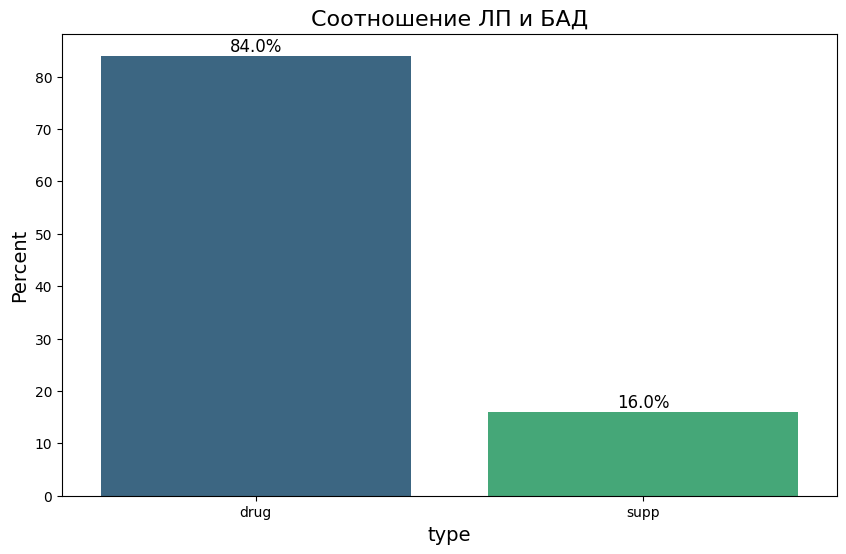

In [120]:
df_target = df['type'].value_counts(
    normalize=True).mul(100).rename('percent').reset_index()

barplot_make(data=df_target,
             col_main='type',
             col_group=None,
             kwargs={},
             title='Соотношение ЛП и БАД')

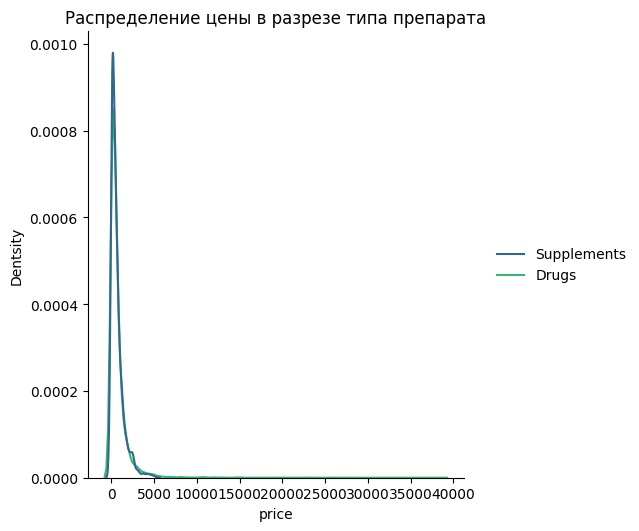

In [122]:
sns.displot(data={
    'Supplements': df[df['type'] == 'supp'].price,
    'Drugs': df[df['type'] == 'drug'].price,
},
            kind="kde",
            common_norm=False,
            palette='viridis')
plt.title('Распределение цены в разрезе типа препарата')
plt.xlabel('price')
plt.ylabel('Dentsity')

plt.show()

**Выводы:**

- Есть количественное преобладание лекарственных препаратов над БАДами, гипотеза подтвердилась
- Среди лекарств и БАДов больше распространены препараты нижнего ценового сегмента, но для ЛП есть дорогостоящие препараты 

## Гипотеза 2

Есть преобладание иностранных препаратов среди БАД и ЛП.

In [110]:
def group_data(df_data: pd.DataFrame, col_main: str,
               col_group: str) -> pd.DataFrame:
    """
    Нормирование данных.
    
    Parameters
    ----------
    df_data: pd.DataFrame
        Исходные данные.
    col_main: str
         Название столбца с основными значениями.
    col_group: str
        Название столбца для группировки данных.
        
    Returns
    -------
    pd.DataFrame
        Датасет с нормированными данными.
    """
    return df_data.groupby(
        [col_group])[col_main].value_counts(normalize=True).rename(
            'percent').mul(100).reset_index().sort_values(col_group)

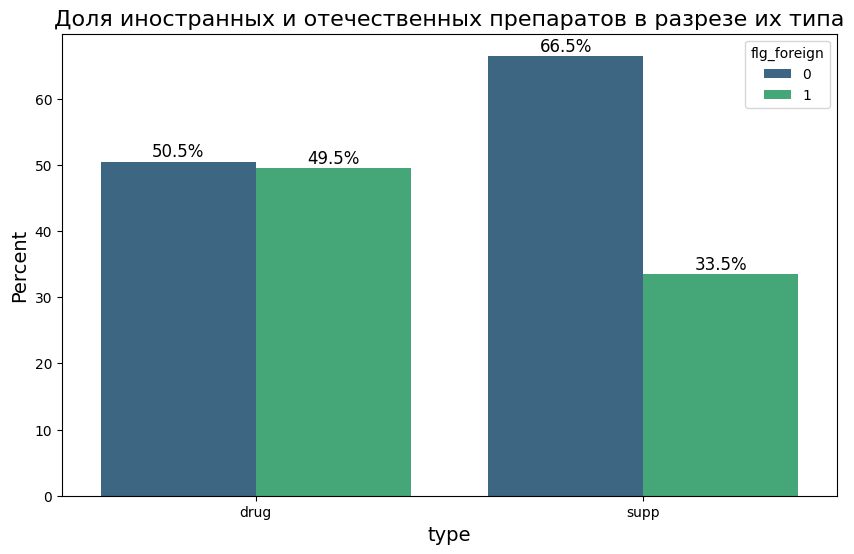

In [123]:
data_countr = group_data(
    df_data=df,
    col_main='flg_foreign',
    col_group='type',
)
barplot_make(
    data=data_countr,
    col_main='type',
    col_group='flg_foreign',
    kwargs={'hue': 'flg_foreign'},
    title='Доля иностранных и отечественных препаратов в разрезе их типа',
#     flg_legend=True
)

**Выводы:**
    
- Гипотеза не подтвердилась. Для ЛП количество иностранных и отечественны препараов примерно на одном уровне. Для БАД преобладают отечественные препараты

## Гипотеза 3

БАДы чаще представлены препаратами для приема внутрь, для ЛП разнообразие больше.

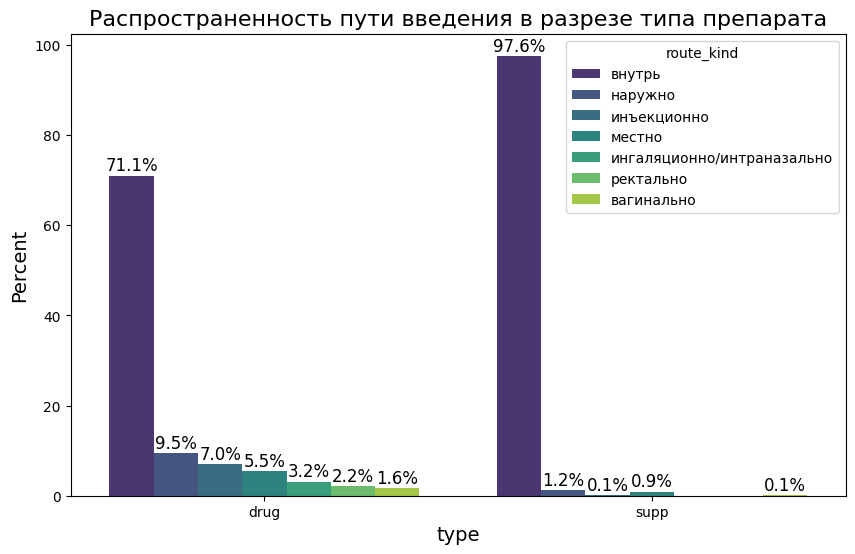

In [124]:
data_route = group_data(
    df_data=df,
    col_main='route_kind',
    col_group='type',
)
barplot_make(
    data=data_route,
    col_main='type',
    col_group='route_kind',
    kwargs={'hue': 'route_kind'},
    title='Распространенность пути введения в разрезе типа препарата',
#     flg_legend=True
)


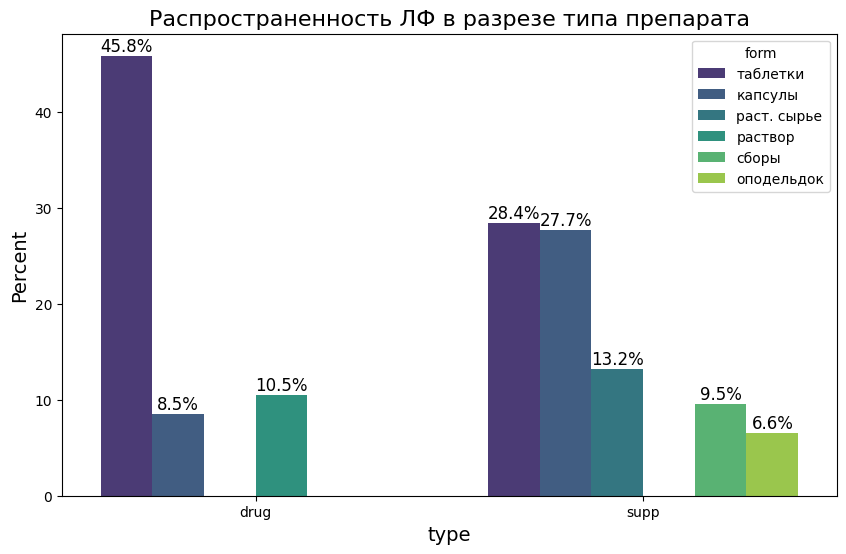

In [125]:
data = group_data(df_data=df, col_main='form', col_group='type')
data_type = data.sort_values('percent', ascending=False)[:8]

barplot_make(
    data=data_type,
    col_main='type',
    col_group='form',
    kwargs={'hue': 'form'},
    title='Распространенность ЛФ в разрезе типа препарата',
#     flg_legend=True
)

**Выводы:**
    
- Среди ЛП больше разнообразие путей введения, среди БАД больше всего препаратов для приема внутрь, гипотеза подтвердилась
- Среди БАД больше распространены ЛФ для внутреннего введения (табл, капс), а также растительные препараты. Среди ЛП есть различные ЛФ: преобладают таблетки, далее раствор, капсулы и капли

## Гипотеза 4

Существует преобладание сердечной группы препаратов.

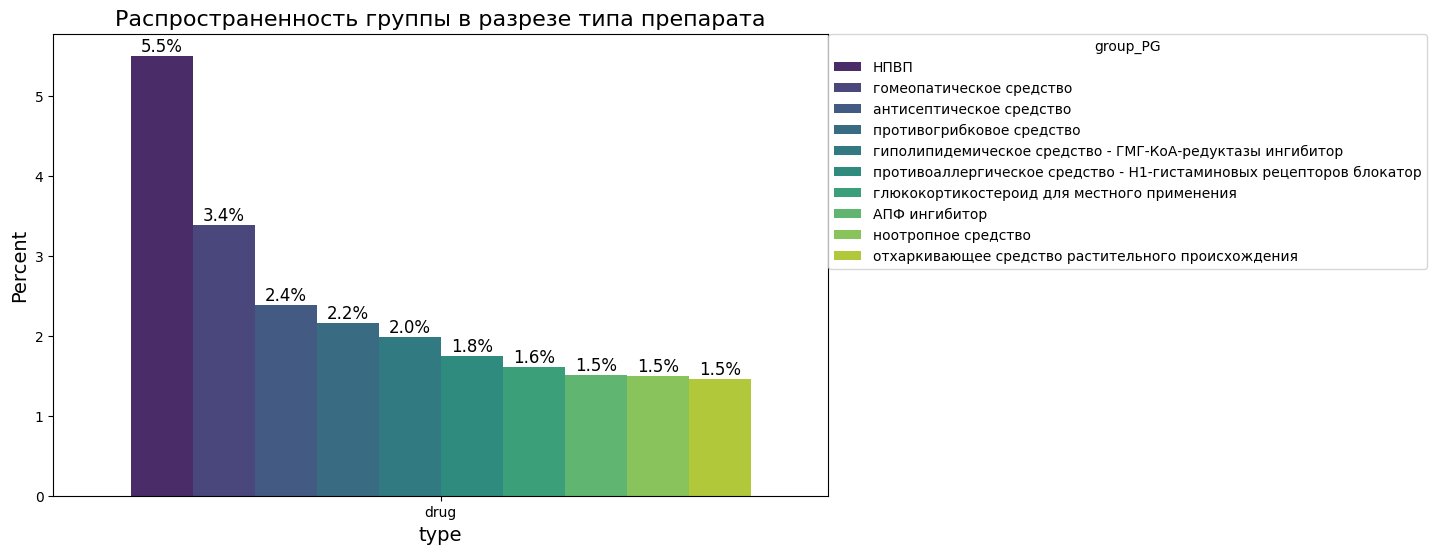

In [126]:
data = group_data(
    df_data=df,
    col_main='group_PG',
    col_group='type',
)
data_PG = data[data['type'] == 'drug'].sort_values('percent',
                                                   ascending=False)[:10]
barplot_make(
    data=data_PG,
    col_main='type',
    col_group='group_PG',
    kwargs={'hue': 'group_PG'},
    title='Распространенность группы в разрезе типа препарата',
    flg_legend=True
)

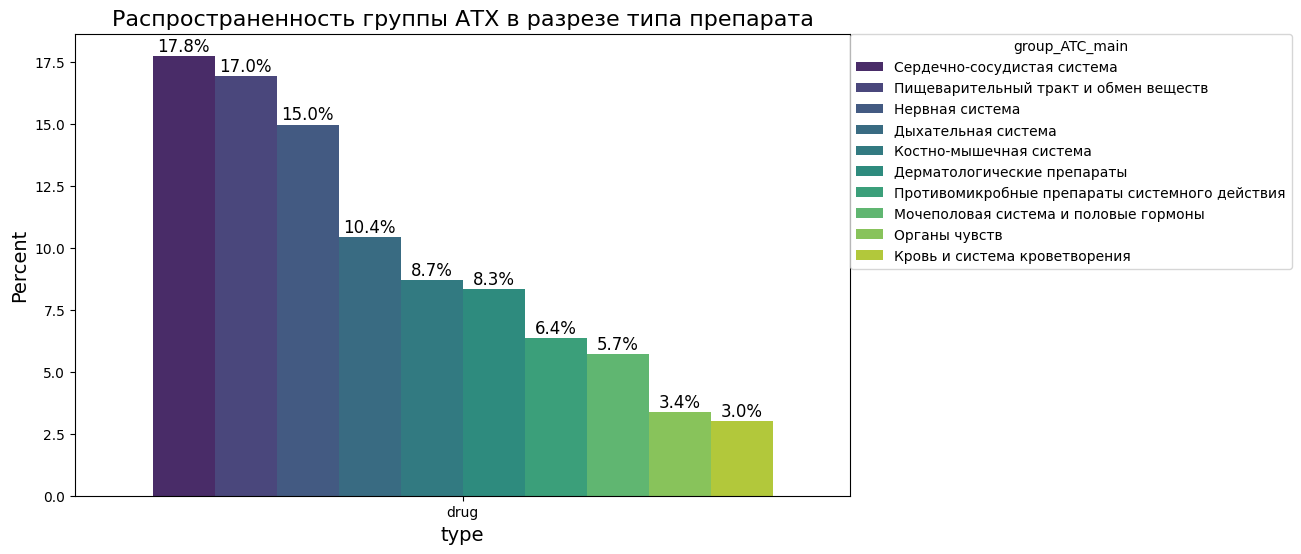

In [127]:
data = group_data(
    df_data=df,
    col_main='group_ATC_main',
    col_group='type',
)
data_ATC = data[data['type'] == 'drug'].sort_values('percent',
                                                    ascending=False)[:10]
barplot_make(data=data_ATC,
             col_main='type',
             col_group='group_ATC_main',
             kwargs={'hue': 'group_ATC_main'},
             title='Распространенность группы АТХ в разрезе типа препарата',
             flg_legend=True)

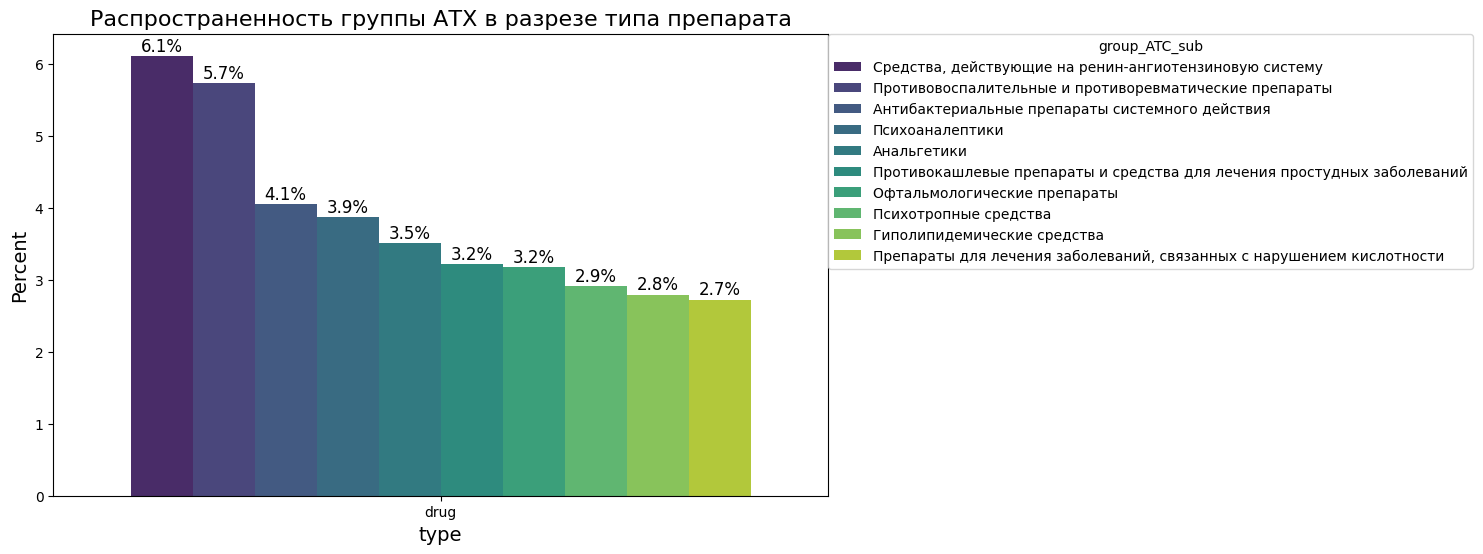

In [128]:
data = group_data(
    df_data=df,
    col_main='group_ATC_sub',
    col_group='type',
)
data_ATC = data[data['type'] == 'drug'].sort_values('percent',
                                                    ascending=False)[:10]
barplot_make(data=data_ATC,
             col_main='type',
             col_group='group_ATC_sub',
             kwargs={'hue': 'group_ATC_sub'},
             title='Распространенность группы АТХ в разрезе типа препарата',
             flg_legend=True)

**Выводы:**

- По АТХ на первом месте стоит подгруппа препаратов для лечения сердечно-сосудистой системы, что подтверждает гипотезу. Далее располагаются препараты для пищеварительной системы, нервной, костной и дыхательной систем
- По ФТГ одна из групп сердечных препаратов находится только на 5 месте, что может быть связано с большим разбиением сердечной группы на подгруппы. На первом месте по распространенности среди ЛП стоят обезболивающие препараты НПВС, на втором - гомеопатичесский препараты (данный факт может быть связан с особенностью ассортимента аптеки, а также популярностью гомеопатии в России)

## Гипотеза 5

Существуют отличия между разными группами препаратов (в разрезе цены, страны производства, применения при беременности и лактации и тд).

1. Анализ различий в разрезе применения беременными

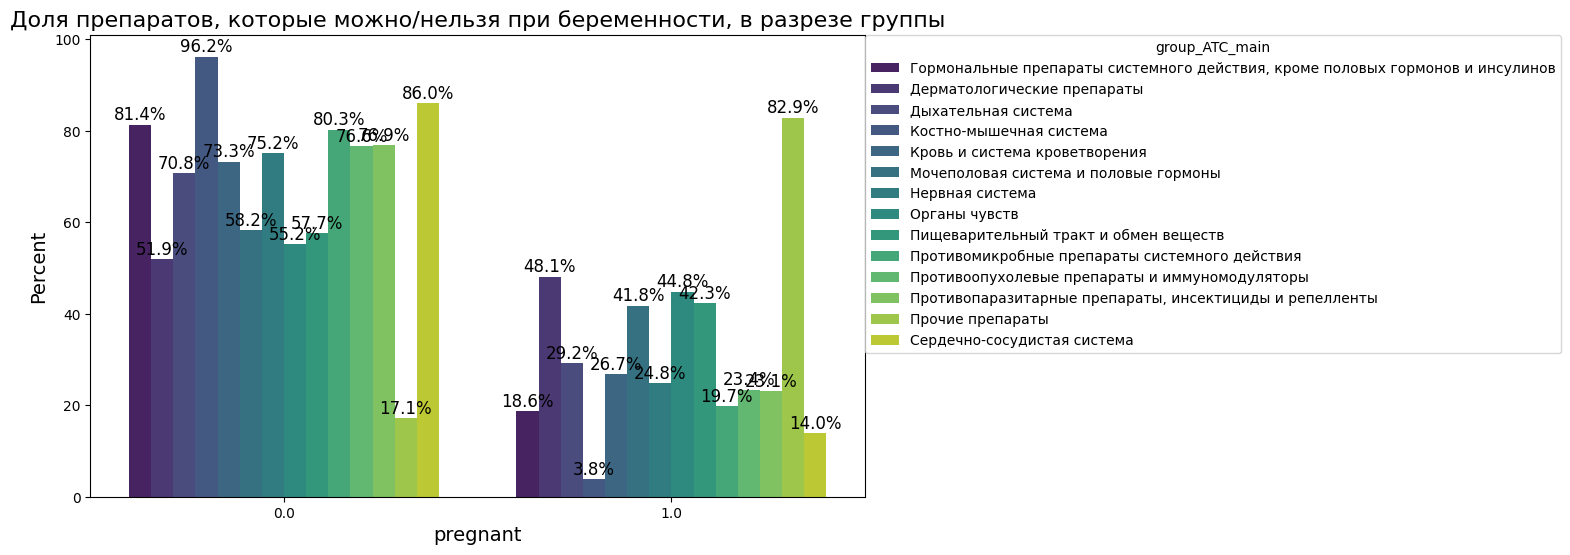

In [132]:
data = group_data(
    df_data=df,
    col_main='pregnant',
    col_group='group_ATC_main',
)
barplot_make(
    data=data,
    col_main='pregnant',
    col_group='group_ATC_main',
    kwargs={'hue': 'group_ATC_main'},
    title=
    'Доля препаратов, которые можно/нельзя при беременности, в разрезе группы',
    flg_legend=True)

*В основном препараты всех групп запрещены при беременности (кроме группы Прочие препараты)*

2. Анализ различий в разрезе применения при грудном вскармливании

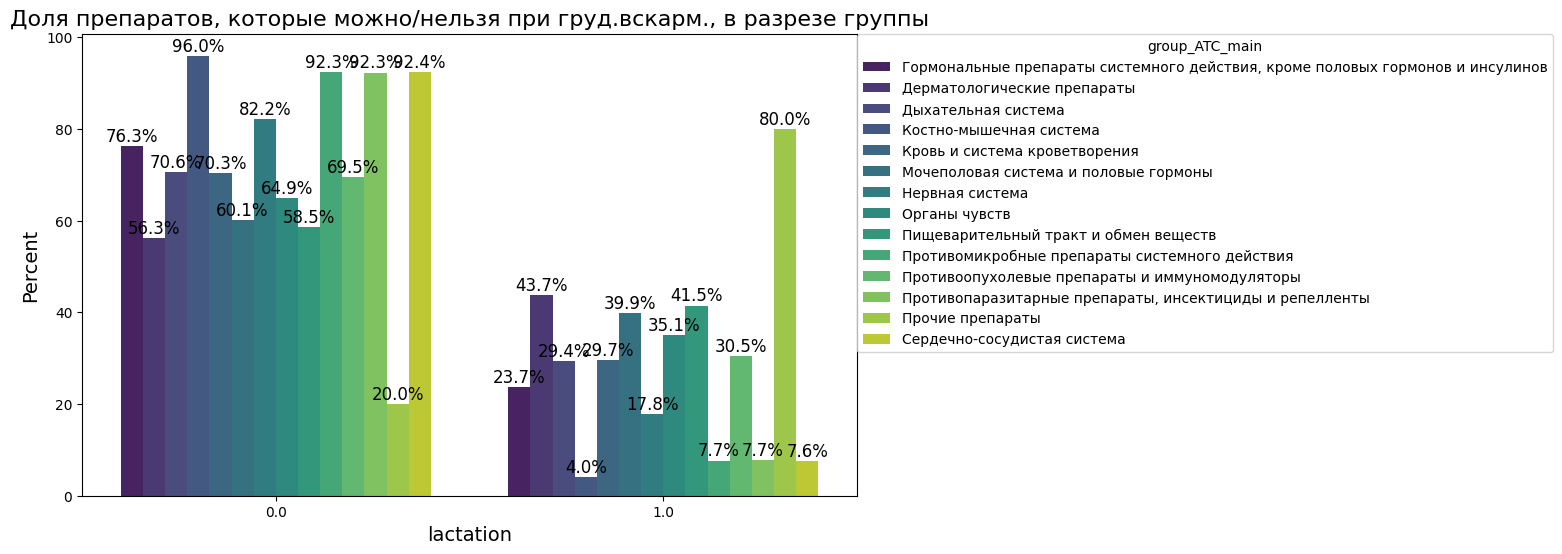

In [133]:
data = group_data(
    df_data=df,
    col_main='lactation',
    col_group='group_ATC_main',
)
barplot_make(
    data=data,
    col_main='lactation',
    col_group='group_ATC_main',
    kwargs={'hue': 'group_ATC_main'},
    title=
    'Доля препаратов, которые можно/нельзя при груд.вскарм., в разрезе группы',
    flg_legend=True)

*В основном препараты всех групп запрещены при лактации (кроме группы Прочие препараты). Данный признак по распределению очень похож на признак беременности*

3. Анализ различий в разрезе применения детьми

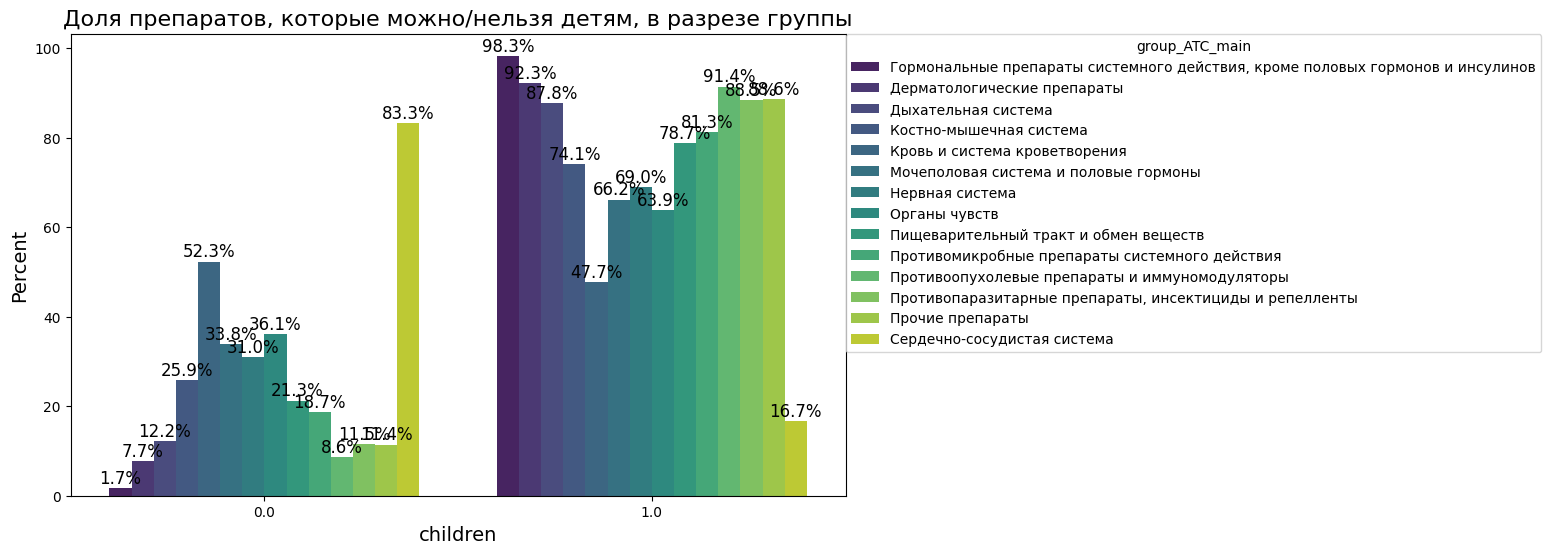

In [135]:
data = group_data(
    df_data=df,
    col_main='children',
    col_group='group_ATC_main',
)
barplot_make(
    data=data,
    col_main='children',
    col_group='group_ATC_main',
    kwargs={'hue': 'group_ATC_main'},
    title=
    'Доля препаратов, которые можно/нельзя детям, в разрезе группы',
    flg_legend=True)

*В основном препараты всех групп разрешены детям (кроме сердечных и для системы кроветворения)*

4. Анализ различий в разрезе препаратов ЖНВЛП

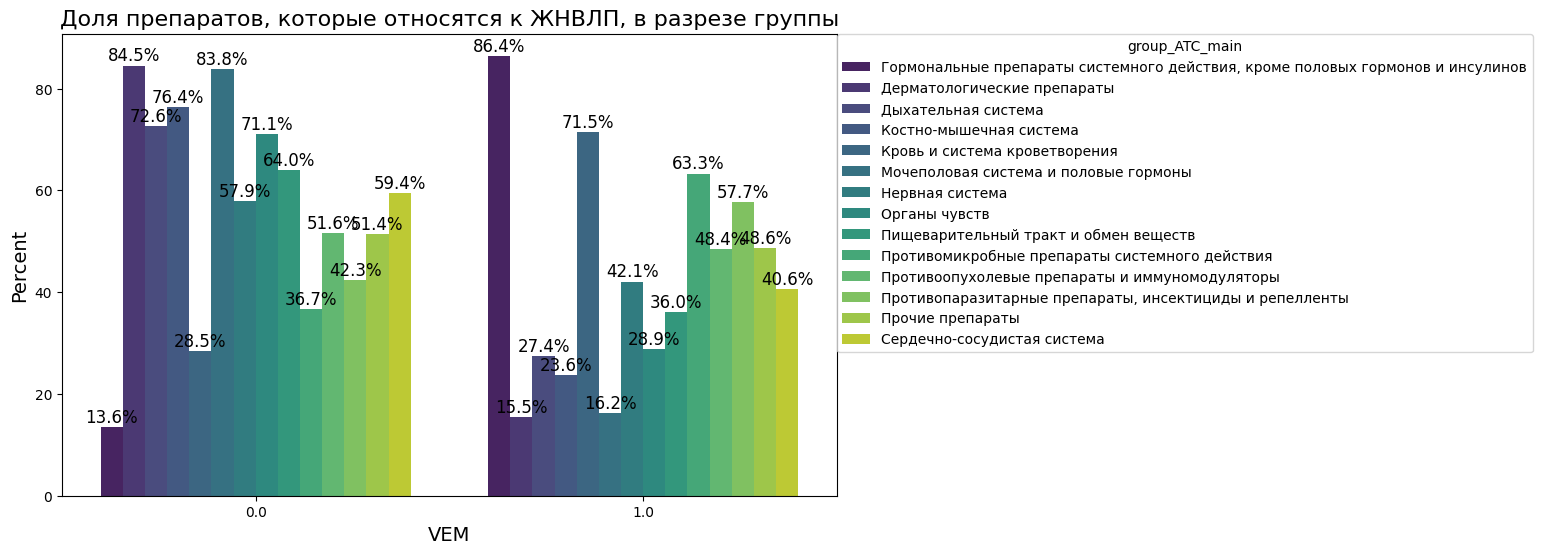

In [137]:
data = group_data(
    df_data=df,
    col_main='VEM',
    col_group='group_ATC_main',
)
barplot_make(
    data=data,
    col_main='VEM',
    col_group='group_ATC_main',
    kwargs={'hue': 'group_ATC_main'},
    title=
    'Доля препаратов, которые относятся к ЖНВЛП, в разрезе группы',
    flg_legend=True)

*Для групп гормональных препаратов, системы кроветворения, противомикробны и противопаразитарных препаратов преобладают препараты ЖНВЛП*

5. Анализ различий в разрезе страны производства

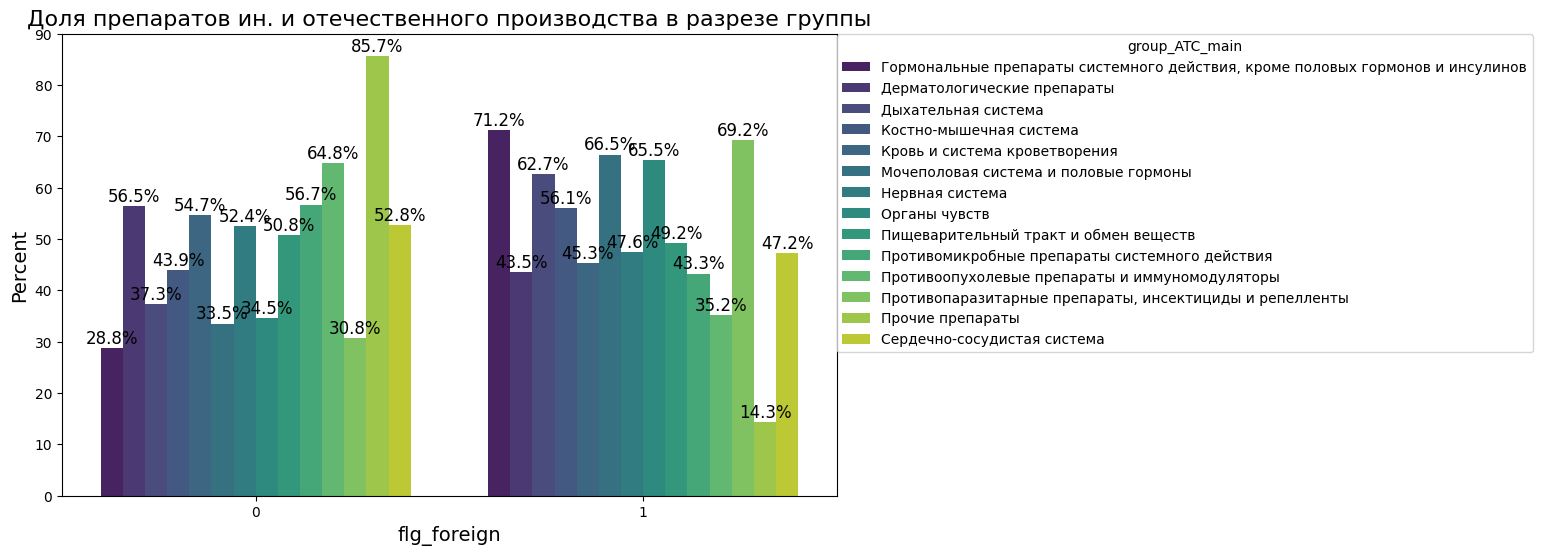

In [138]:
data = group_data(
    df_data=df,
    col_main='flg_foreign',
    col_group='group_ATC_main',
)
barplot_make(
    data=data,
    col_main='flg_foreign',
    col_group='group_ATC_main',
    kwargs={'hue': 'group_ATC_main'},
    title=
    'Доля препаратов ин. и отечественного производства в разрезе группы',
    flg_legend=True)


*Наблюдается различие в стране производства для разных групп препаратов (для большинства преобладают ин. производители)*

6. Анализ различий в разрезе срока годности

In [149]:
def boxplot_make(data: pd.DataFrame, col_main: str, col_group_1: str,
                 col_group_2: str, title: str) -> None:
    """
    Построение boxplot с двумя полями.
    
    Parameters
    ----------
    data: pd.DataFrame
        Данные.
    col_main: str
         Название столбца с основными значениями.
    col_group_1: str
        Название столбца для группировки данных для первого графика.
    col_group_1: str
        Название столбца для группировки данных для первого графика.
    title: str
        Заголовок графика.
        
    Returns
    -------
    None
        Выводит график boxplot.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(15, 7))

    sns.boxplot(x=col_group_1,
                y=col_main,
                data=data,
                palette='viridis',
                ax=axes[0])
    axes[0].set_title(f'Распределение {title} в разрезе группы', fontsize=16)
    axes[0].set_ylabel(col_main, fontsize=14)
    axes[0].set_xlabel(col_group_1, fontsize=14)
    axes[0].tick_params(axis='x', labelrotation=90)

    sns.boxplot(x=col_group_2,
                y=col_main,
                data=data,
                palette='viridis',
                ax=axes[1])
    axes[1].set_title(f'Распределение {title} в разрезе типа', fontsize=16)
    axes[1].set_ylabel(col_main, fontsize=14)
    axes[1].set_xlabel(col_group_2, fontsize=14)
    plt.show()

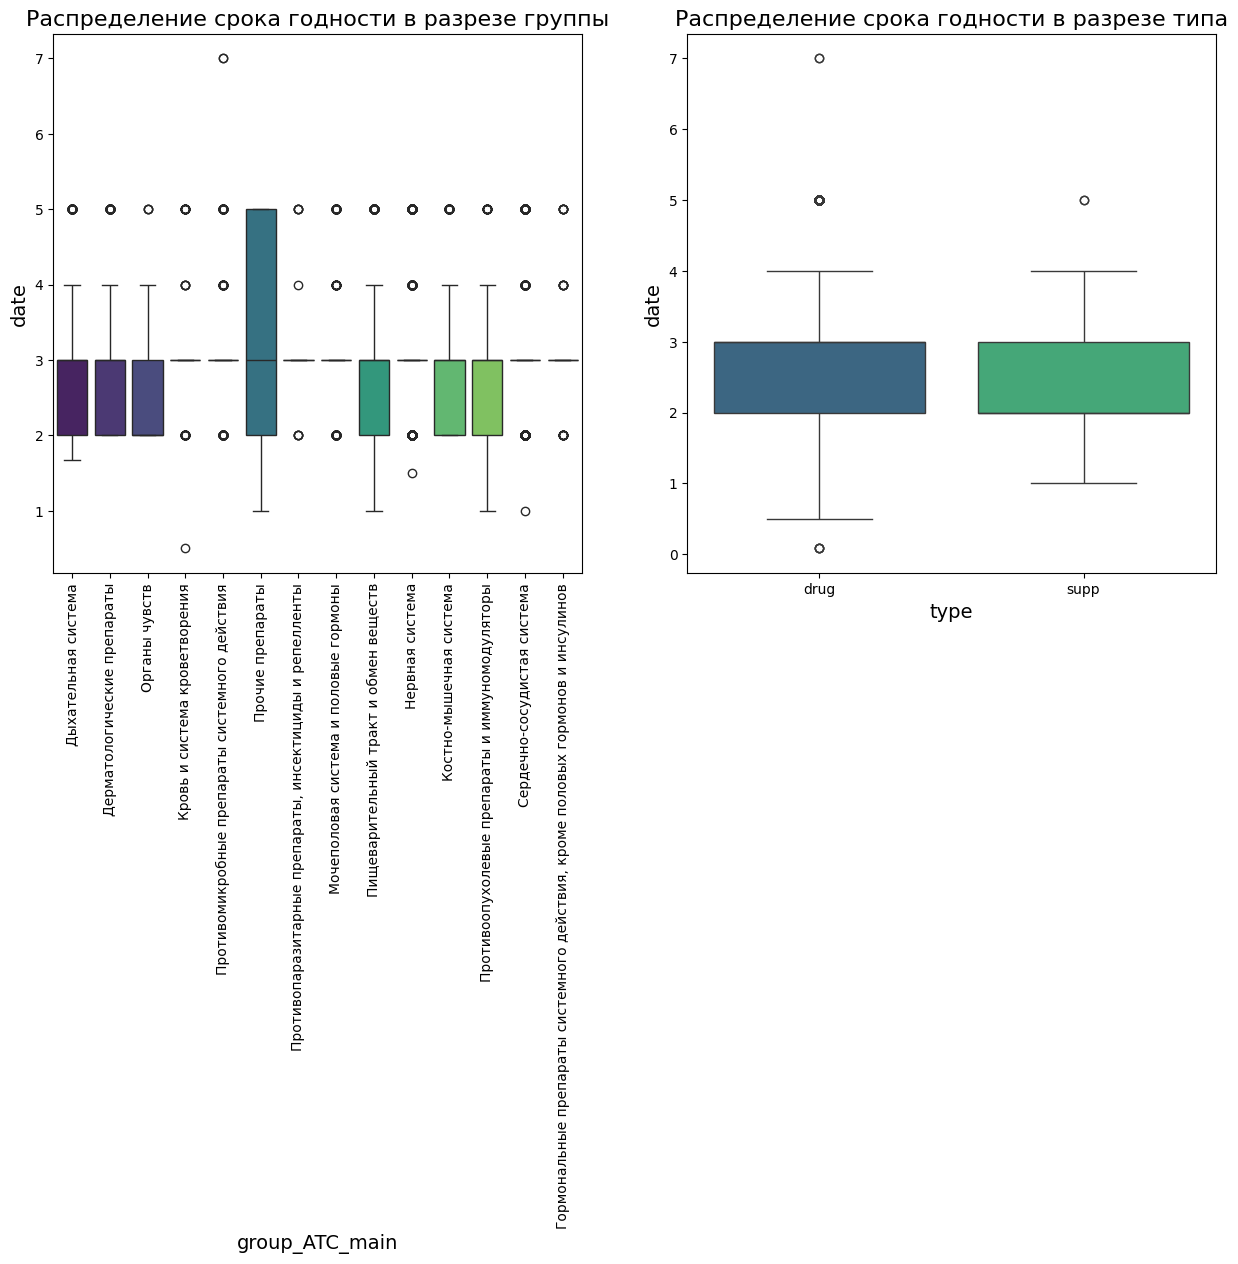

In [150]:
boxplot_make(data=df,
             col_main='date',
             col_group_1='group_ATC_main',
             col_group_2='type',
             title='срока годности')

*Для некоторых групп препаратов есть различия в сроке годности. Для типа препарата различий почти нет*

7. Анализ различий в разрезе цены

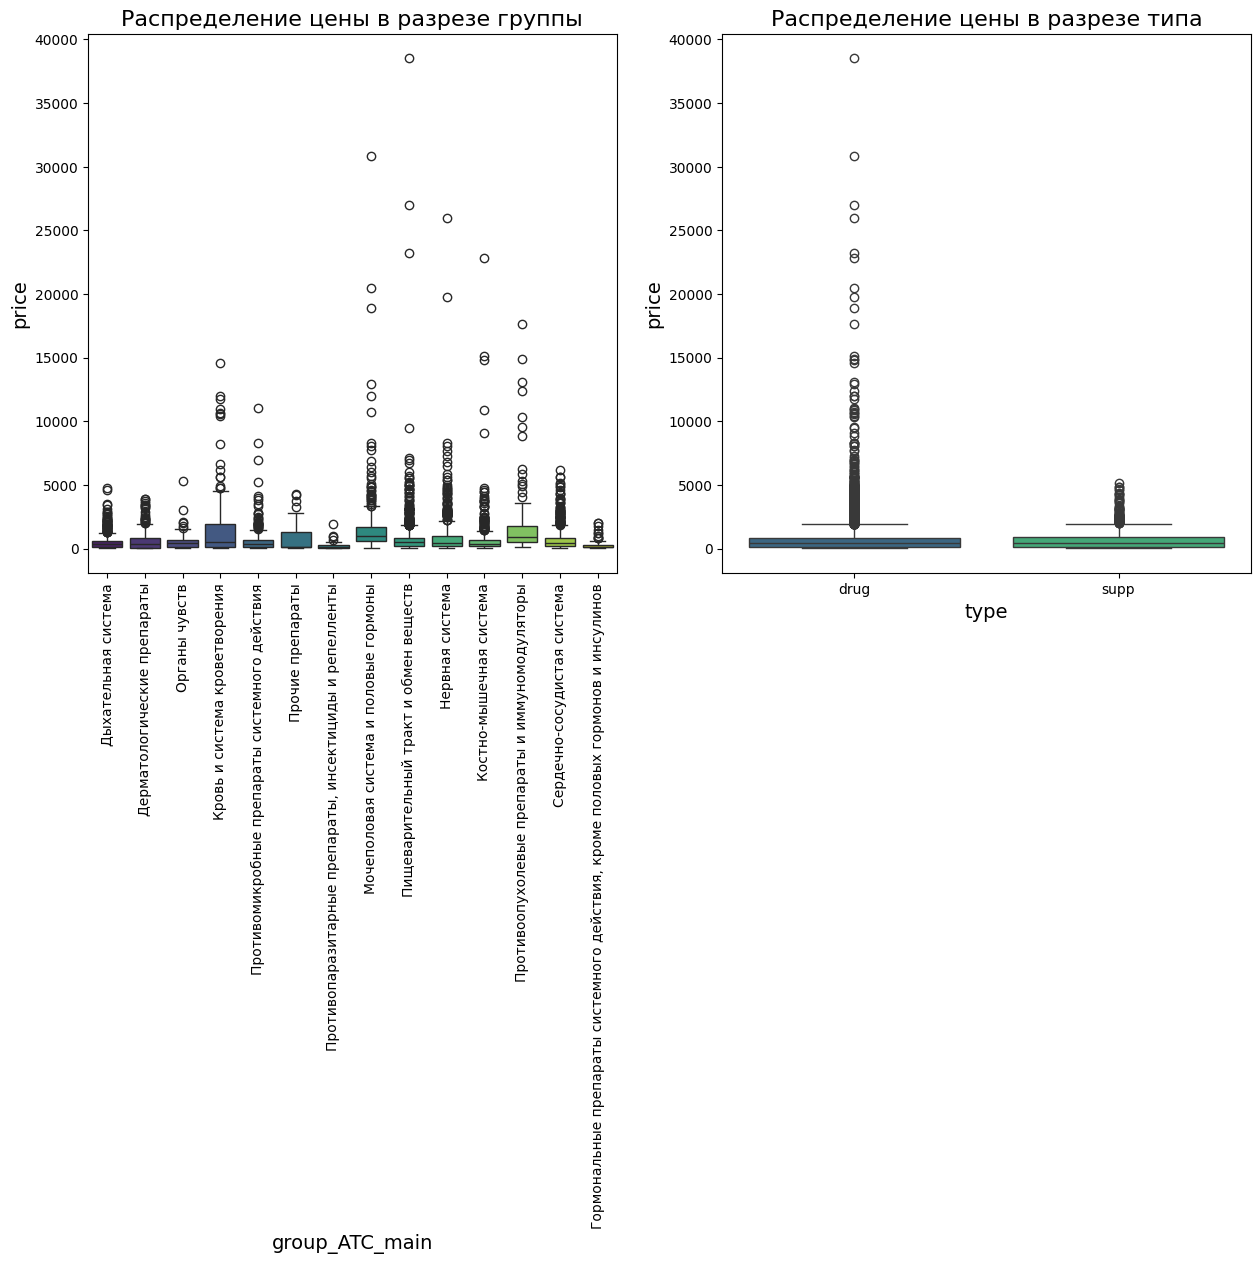

In [151]:
boxplot_make(data=df,
             col_main='price',
             col_group_1='group_ATC_main',
             col_group_2='type',
             title='цены')

*За счет многообразия препаратов у типа ЛП больше ценовое разнообразие. Также наблюдается различие цен по группам*

8. Анализ различий в разрезе температуры хранения

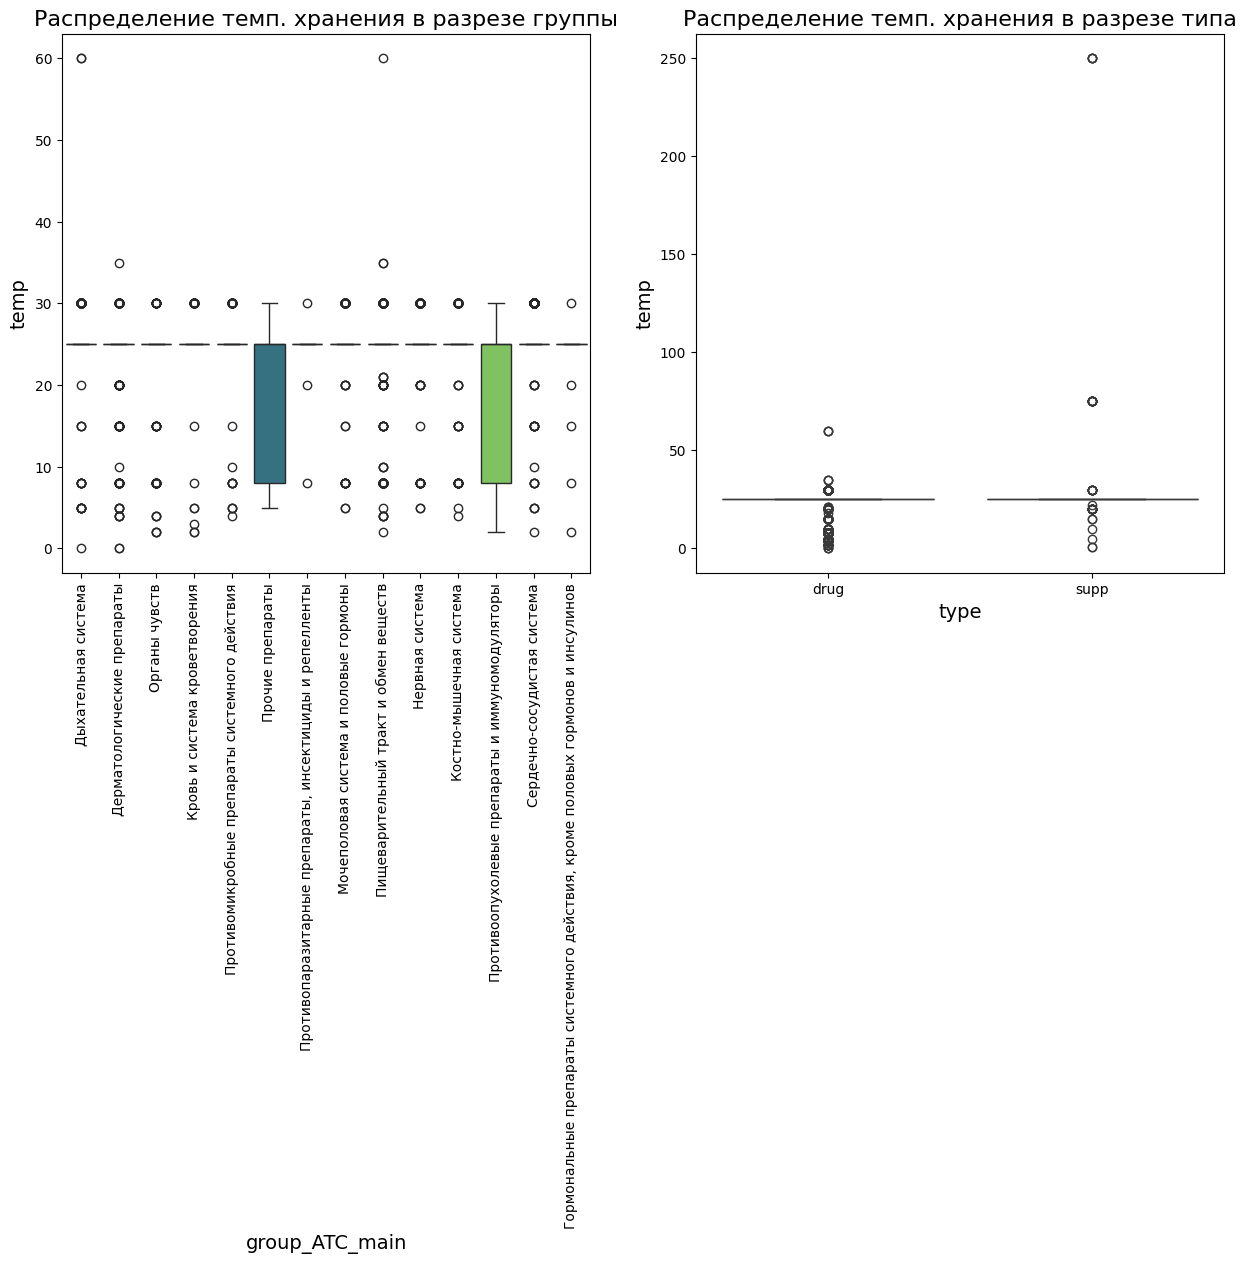

In [152]:
boxplot_make(data=df,
             col_main='temp',
             col_group_1='group_ATC_main',
             col_group_2='type',
             title='темп. хранения')

*Среди прочих и противоопухолевых препаратов распространены более низкие температуры хранения. Для типа препарата различий почти нет*

9. Анализ различий в разрезе количества в упаковке

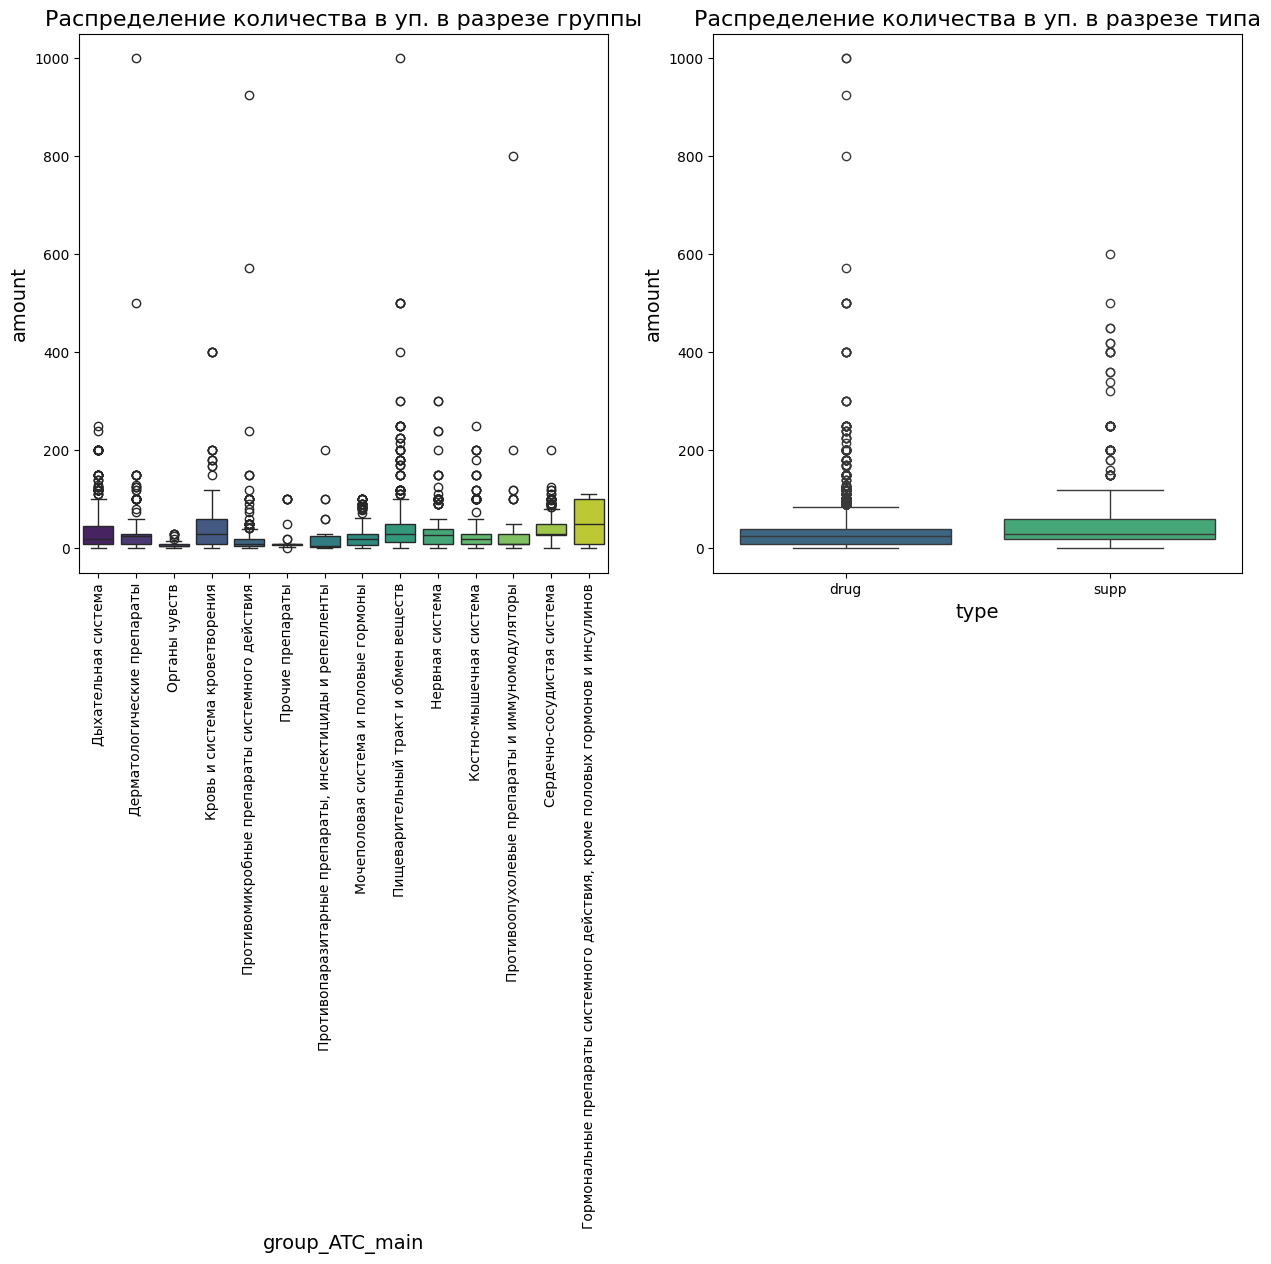

In [153]:
boxplot_make(data=df,
             col_main='amount',
             col_group_1='group_ATC_main',
             col_group_2='type',
             title='количества в уп.')

*Наблюдаются различия в количестве препарата по группе и типу, что связано с различием в распределении ЛФ по группам*

**Выводы:**
- Между группами наблюдаются различия, что в дальнейшем может помочь в выделении кластеров

## Гипотеза 6

БАДы чаще запрещены детям, беременным и лактирующим в сравнении с ЛП.

1. Анализ в разрезе "беременности"

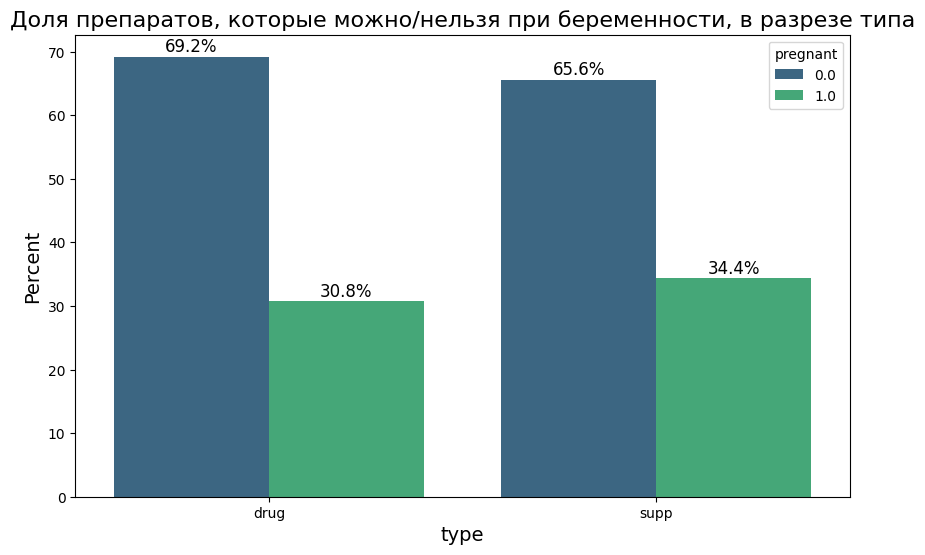

In [155]:
data = group_data(
    df_data=df,
    col_main='pregnant',
    col_group='type',
)
barplot_make(
    data=data,
    col_main='type',
    col_group='pregnant',
    kwargs={'hue': 'pregnant'},
    title=
    'Доля препаратов, которые можно/нельзя при беременности, в разрезе типа',
    #     flg_legend=True
)

2. Анализ в разрезе "лактации"

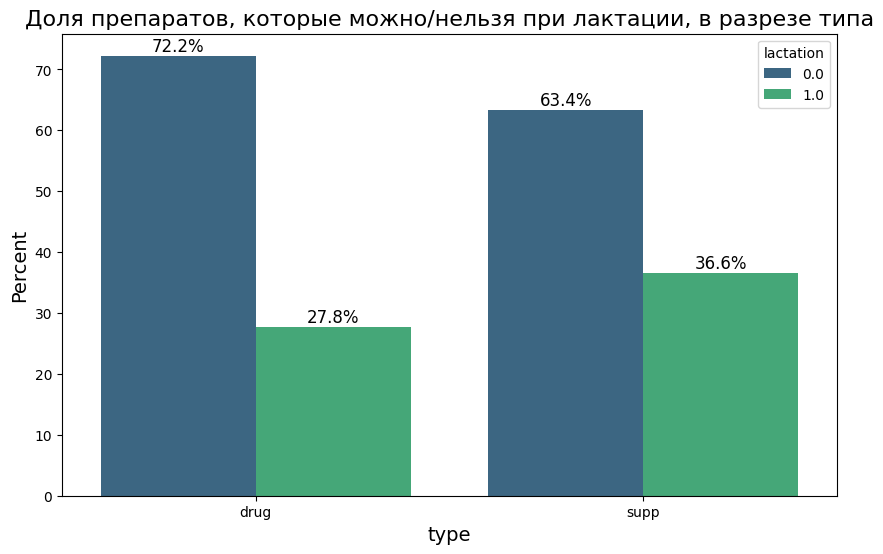

In [156]:
data = group_data(
    df_data=df,
    col_main='lactation',
    col_group='type',
)
barplot_make(
    data=data,
    col_main='type',
    col_group='lactation',
    kwargs={'hue': 'lactation'},
    title=
    'Доля препаратов, которые можно/нельзя при лактации, в разрезе типа',
    #     flg_legend=True
)

3. Анализ в разрезе "детей"

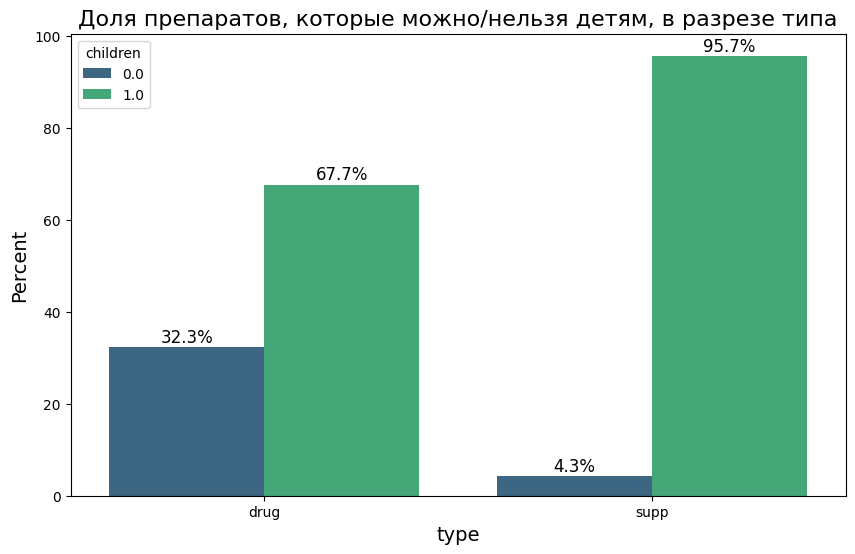

In [157]:
data = group_data(
    df_data=df,
    col_main='children',
    col_group='type',
)
barplot_make(
    data=data,
    col_main='type',
    col_group='children',
    kwargs={'hue': 'children'},
    title=
    'Доля препаратов, которые можно/нельзя детям, в разрезе типа',
    #     flg_legend=True
)

**Выводы:**
    
- В большей степени БАД можно детям (в сравнении с ЛП), в большей степени можно кормящим мамам. В части беременности распределение примерно одинаково для БАД и ЛП. Гипотеза не подтвердилась
- Данное наблюдение может быть связано с тем, что часть БАДов выпускается для беременных; ЛП более изучены и применяются в том числе в тех сферах, где БАД нет; БАД - это пищевая добавка, которая не выделяется с молоком, поэтому их чаще можно при беременности (также для них проведено меньше исследований); часть БАД сощдана именно для детей

## Гипотеза 7

Существует связь между типом отпуска препарата и группой, к которой он относится.

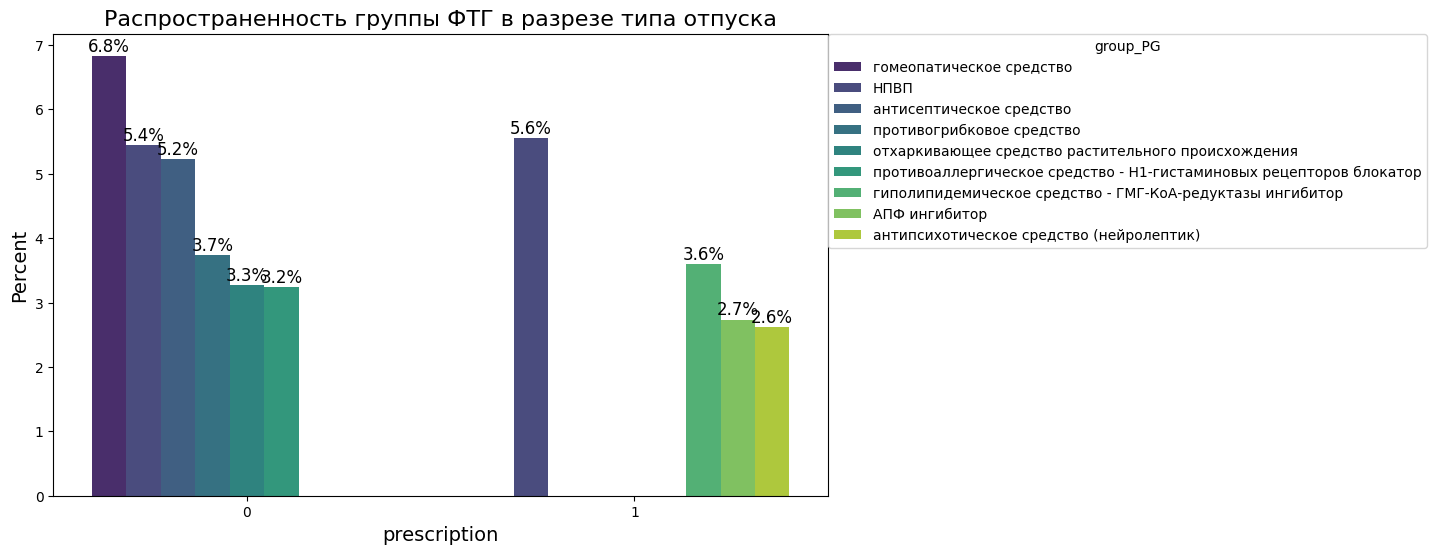

In [158]:
data = group_data(
    df_data=df[df['type'] == 'drug'],
    col_main='group_PG',
    col_group='prescription',
)
data_PG = data.sort_values('percent', ascending=False)[:10]
barplot_make(data=data_PG,
             col_main='prescription',
             col_group='group_PG',
             kwargs={'hue': 'group_PG'},
             title='Распространенность группы ФТГ в разрезе типа отпуска',
             flg_legend=True)

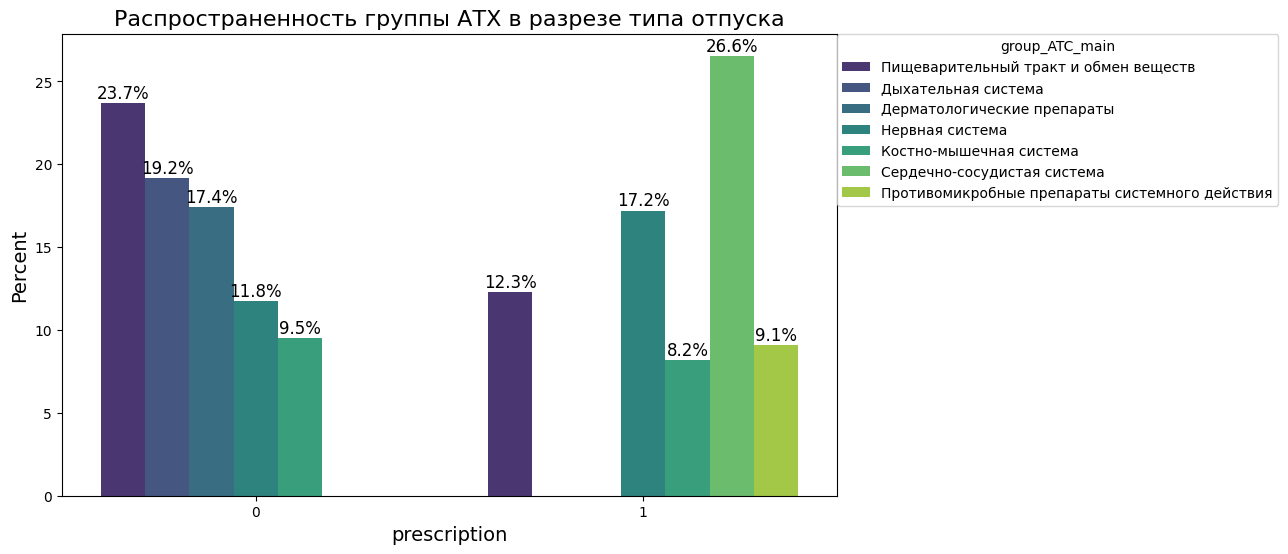

In [159]:
data = group_data(
    df_data=df[df['type'] == 'drug'],
    col_main='group_ATC_main',
    col_group='prescription',
)
data_ATC = data.sort_values('percent', ascending=False)[:10]
barplot_make(data=data_ATC,
             col_main='prescription',
             col_group='group_ATC_main',
             kwargs={'hue': 'group_ATC_main'},
             title='Распространенность группы АТХ в разрезе типа отпуска',
             flg_legend=True)

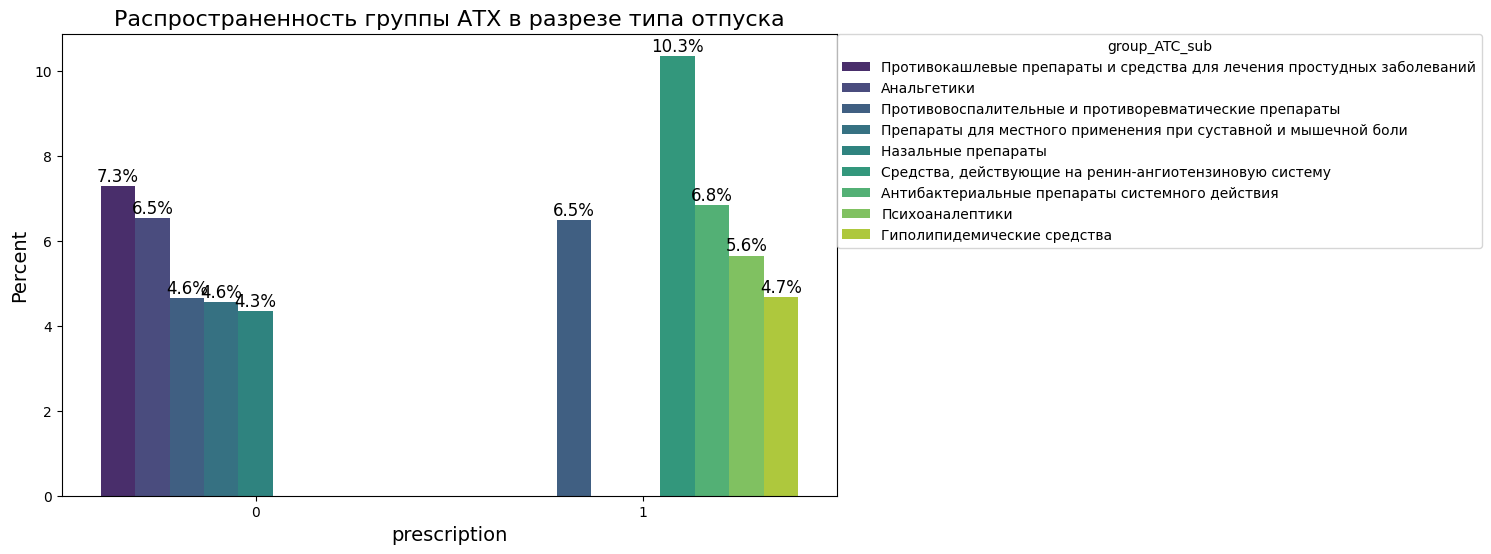

In [160]:
data = group_data(
    df_data=df[df['type'] == 'drug'],
    col_main='group_ATC_sub',
    col_group='prescription',
)
data_ATC = data.sort_values('percent', ascending=False)[:10]
barplot_make(data=data_ATC,
             col_main='prescription',
             col_group='group_ATC_sub',
             kwargs={'hue': 'group_ATC_sub'},
             title='Распространенность группы АТХ в разрезе типа отпуска',
             flg_legend=True)

**Выводы:**
    
- Гипотеза подствердилась - среди рецептурных препаратов выделяются группы препаратов для ССС, ЦНС и антибиотики. Среди безрецептурных распространены гомеопатические препараты, обезболивающие, препараты при кашле

## Гипотеза 8

Для препаратов ЖНВЛ ниже ценовой сегмент, они чаще отпускаются без рецепта.

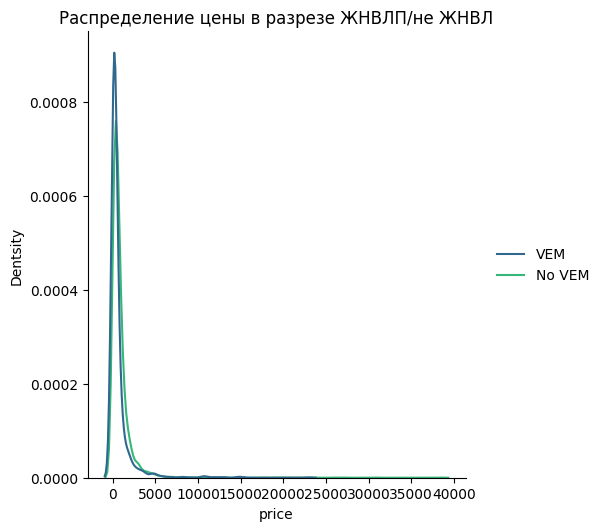

In [161]:
sns.displot(data={
    'VEM': df[df['VEM'] == 1].price,
    'No VEM': df[df['VEM'] == 0].price,
},
            kind="kde",
            common_norm=False,
           palette='viridis')
plt.title('Распределение цены в разрезе ЖНВЛП/не ЖНВЛ')
plt.xlabel('price')
plt.ylabel('Dentsity')

plt.show()

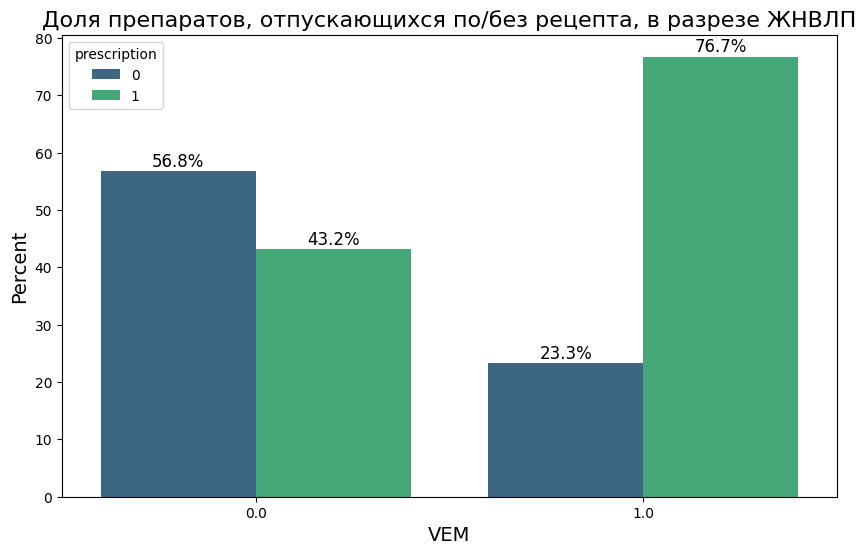

In [163]:
data = group_data(
    df_data=df,
    col_main='prescription',
    col_group='VEM',
)
barplot_make(
    data=data,
    col_main='VEM',
    col_group='prescription',
    kwargs={'hue': 'prescription'},
    title='Доля препаратов, отпускающихся по/без рецепта, в разрезе ЖНВЛП',
#     flg_legend=True
)

**Выводы:**
    
- Гипотеза подтвердилась частично: ценовой сегмент препаратов, не относящихся к ЖНВЛП, чуть выше (что связано с гос регулированием цен). При этом среди препаратов ЖНВЛП больше рецептурных препаратов

## Корреляция между признаками

In [164]:
num_features = ['price', 'date', 'temp', 'amount']

df_numeric = df[num_features]

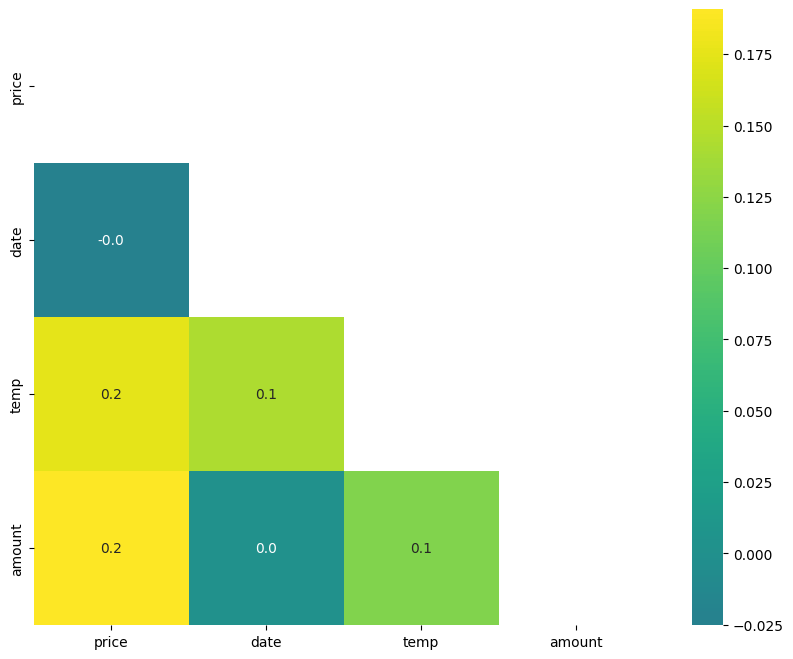

In [165]:
matrix = np.triu(df_numeric.corr(method='spearman', numeric_only=True))

plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(method='spearman', numeric_only=True),
            annot=True,
            center=0,
            fmt='.1f',
            cmap='viridis',
            mask=matrix)
plt.show()

*Не наблюдается значительной корреляции между признаками*

# Работа с пропусками

Удалим часть признаков

In [194]:
# удалим признак лактации (связана с беременностью)
df = df.drop(['lactation'], axis=1)

In [195]:
# удалим признак срока годности, тк он мало отличается среди групп
df = df.drop(['date'], axis=1)

In [196]:
# удалим колонки с большим количеством уникальных значений
df = df.drop(['active_drug', 'dose', 'producer'], axis=1)

Обработаем выбросы в признаке темепература хранения (temp)

In [197]:
def temp_out(data_temp: float) -> Union[float, None]:
    """
    Функция обработки выбросов температуры хранения. 

    Parameters
    ----------
    data_temp: str
        Строка с информацией о температуре хранения.

    Returns
    -------
    Union[int, None]
        Обработанное значение температуры хранения, если найдено, иначе None
    """
    if isinstance(data_temp, float):
        if data_temp == 250:
            return 25
        else:
            return data_temp
    return None

In [199]:
df['temp'] = df['temp'].apply(temp_out)

Посмотрим на количество пропусков

In [201]:
df.isna().sum()[df.isna().sum() > 0]  / df.shape[0] * 100

type               3.630824
price              0.025390
use_for            0.190428
temp              15.830900
VEM               20.477339
pregnant           2.374000
children           1.155262
amount             0.088866
group_PG           4.468706
group_ATC_main    27.281960
group_ATC_sub     27.281960
route_kind         6.830011
dtype: float64

1. Заполним пропуски в колонках object значением 'информация отсутствует'

In [202]:
cols_obj = [
    'group_ATC_main', 'group_ATC_sub', 'group_PG', 'use_for', 'form',
    'route_kind', 'type'
]

for col in cols_obj:
    df[col] = df[col].fillna('информация отсутствует')

2. Заполним пропуски в признаке price

In [203]:
df[df.price.isna()]

,name,prescription,type,price,form,use_for,temp,VEM,flg_foreign,pregnant,children,amount,group_PG,group_ATC_main,group_ATC_sub,route_kind
2622,Аллохол таблетки покрытые оболочкой № 10,0,drug,NaN,таблетки,"В составе комплексной терапии, хронический реа...",25.0,0.0,0,1.0,1.0,10.0,желчегонное средство,Пищеварительный тракт и обмен веществ,Препараты для лечения заболеваний печени и жел...,внутрь
6133,Роксера таблетки покрытые пленочной оболочкой ...,1,drug,NaN,таблетки,Первичная гиперхолестеринемия по классификации...,25.0,0.0,1,0.0,0.0,90.0,гиполипидемическое средство - ГМГ-КоА-редуктаз...,Сердечно-сосудистая система,Гиполипидемические средства,внутрь


Найдем пропущенные значения цены на сайте и заполнм пропуски

In [220]:
def fill_price(data_price: float, data_name: str) -> float:
    """
    Заполнение пропусков в признаке цена.

    Parameters
    ----------
    data_price: float
        Строка с информацией о цене.
    data_name: str
        Строка с информацией о наименовании препарата.

    Returns
    -------
    float
        Значение цены в формате float.
    """
    if np.isnan(data_price):
        if 'Аллохол' in data_name:
            return 20.0
        elif 'Роксера' in data_name:
            return 727.0

    return data_price

In [221]:
df['price'] = df.apply(
    lambda x: fill_price(data_price=x['price'], data_name=x['name']), axis=1)

3. Заполним пропуске в признаке количество в упаковке (amount)

In [223]:
df['amount'] = df['amount'].fillna(1)

4. Заполним модой значения в temp, pregnant, children, VEM

In [224]:
for column in ['temp', 'pregnant', 'children', 'VEM']:
    df[column] = df[column].fillna(
        df.groupby('group_ATC_main')[column].transform(lambda x: x.mode()[0]))

Проверим, все ли заполнено

In [225]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7877 entries, 0 to 7876
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            7877 non-null   object 
 1   prescription    7877 non-null   int64  
 2   type            7877 non-null   object 
 3   price           7877 non-null   float64
 4   form            7877 non-null   object 
 5   use_for         7877 non-null   object 
 6   temp            7877 non-null   float64
 7   VEM             7877 non-null   float64
 8   flg_foreign     7877 non-null   int64  
 9   pregnant        7877 non-null   float64
 10  children        7877 non-null   float64
 11  amount          7877 non-null   float64
 12  group_PG        7877 non-null   object 
 13  group_ATC_main  7877 non-null   object 
 14  group_ATC_sub   7877 non-null   object 
 15  route_kind      7877 non-null   object 
dtypes: float64(6), int64(2), object(8)
memory usage: 984.8+ KB


# Сохранение датасета в файл csv

In [226]:
df.to_csv('data/df_res_data.csv', index=False)